In [4]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from os import listdir
from os.path import isfile, join

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline


In [5]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified .\notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified .\notMNIST_small.tar.gz


In [6]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)


Extracting data for .\notMNIST_large. This may take a while. Please wait.
['.\\notMNIST_large\\A', '.\\notMNIST_large\\B', '.\\notMNIST_large\\C', '.\\notMNIST_large\\D', '.\\notMNIST_large\\E', '.\\notMNIST_large\\F', '.\\notMNIST_large\\G', '.\\notMNIST_large\\H', '.\\notMNIST_large\\I', '.\\notMNIST_large\\J']
Extracting data for .\notMNIST_small. This may take a while. Please wait.
['.\\notMNIST_small\\A', '.\\notMNIST_small\\B', '.\\notMNIST_small\\C', '.\\notMNIST_small\\D', '.\\notMNIST_small\\E', '.\\notMNIST_small\\F', '.\\notMNIST_small\\G', '.\\notMNIST_small\\H', '.\\notMNIST_small\\I', '.\\notMNIST_small\\J']


In [7]:
folder = "notMNIST_LARGE/A"
onlyfiles = [f for f in listdir(folder) if isfile(join(folder, f))]
file = folder + "/" + onlyfiles[-1]
print(file)
Image(filename=file)

notMNIST_LARGE/A/ZXVyb2Z1cmVuY2UgYm9sZGl0YWxpYy50dGY=.png


In [8]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling .\notMNIST_large\A.pickle.
.\notMNIST_large\A
Could not read: .\notMNIST_large\A\RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file '.\\notMNIST_large\\A\\RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read: .\notMNIST_large\A\SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file '.\\notMNIST_large\\A\\SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: .\notMNIST_large\A\Um9tYW5hIEJvbGQucGZi.png : cannot identify image file '.\\notMNIST_large\\A\\Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.443121
Pickling .\notMNIST_large\B.pickle.
.\notMNIST_large\B
Could not read: .\notMNIST_large\B\TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file '.\\notMNIST_large\\B\\TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.00756303
Standard deviation: 0.

['.\\notMNIST_large\\A.pickle', '.\\notMNIST_large\\B.pickle', '.\\notMNIST_large\\C.pickle', '.\\notMNIST_large\\D.pickle', '.\\notMNIST_large\\E.pickle', '.\\notMNIST_large\\F.pickle', '.\\notMNIST_large\\G.pickle', '.\\notMNIST_large\\H.pickle', '.\\notMNIST_large\\I.pickle', '.\\notMNIST_large\\J.pickle']


Text(0.5,1,'Char a')

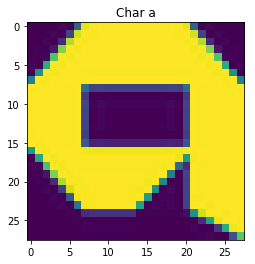

In [39]:
#now going to show some labels
%matplotlib inline
print(train_datasets)
with open(train_datasets[0], 'rb') as f:
        letter_set = pickle.load(f)
plt.imshow(letter_set[0])
plt.title("Char a")

In [41]:
for train_dataset in train_datasets:
    with open(train_dataset, "rb") as f:
        letter_set = pickle.load(f)
    print(len(letter_set))
        

52909
52911
52912
52911
52912
52912
52912
52912
52912
52911


In [132]:

def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes

  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
                
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class

    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000


valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)


print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [139]:
from hashlib import md5

def clean_dataset(md5_set, dataset, labels):
    # checking for dups set
    ind = 0
    clean_dataset = np.empty_like(dataset)
    clean_labels = np.empty_like(labels)

    for index, letter_image in enumerate(dataset):       
        md5_calc = md5(letter_image).hexdigest()
        if md5_calc not in md5_set:
            md5_set.add(md5_calc)
            clean_dataset[ind] = letter_image
            clean_labels[ind]  = labels[index]
            ind += 1

    clean_dataset = clean_dataset[:ind]
    clean_labels  = clean_labels[:ind]
    return clean_dataset, clean_labels



md5_set = set()
train_dataset, train_labels = clean_dataset(md5_set, train_dataset, train_labels)
valid_dataset, valid_labels = clean_dataset(md5_set, valid_dataset, valid_labels)
test_dataset, test_labels = clean_dataset(md5_set, test_dataset, test_labels)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (187341, 28, 28) (187341,)
Validation: (8888, 28, 28) (8888,)
Testing: (8620, 28, 28) (8620,)


In [140]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

B


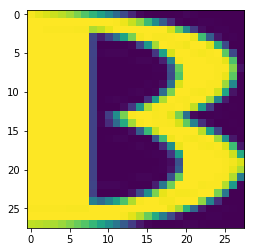

In [141]:
def check_letter(dataset, label):
    #function will show name of letter based on label
    def letter(i):
        return 'ABCDEFGHIJ'[i]
    n = np.random.randint(len(dataset[:]))
    plt.imshow(dataset[n])
    print(letter(labels[n]))

In [142]:
pickle_file = os.path.join(data_root, 'notMNIST_sanitized.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [143]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 643226366


In [144]:
#lets use md5 hasing to measure the overlap between something
from hashlib import md5
#prepare image hashes
%time set_valid_dataset = set([ md5(x).hexdigest() for x in valid_dataset])
%time set_test_dataset = set([ md5(x).hexdigest() for x in test_dataset])
%time set_train_dataset = set([ md5(x).hexdigest() for x in train_dataset])

#measure overlaps and print them
overlap_test_valid = set_test_dataset - set_valid_dataset
print('overlap test valid: ' + str(len(overlap_test_valid)))

overlap_train_valid = set_train_dataset - set_valid_dataset
print ('overlap train valid: ' + str(len(overlap_train_valid)))

overlap_train_test = set_train_dataset - set_test_dataset
print ('overlap train test: ' + str(len(overlap_train_test)))
            

Wall time: 78.1 ms
Wall time: 84.1 ms
Wall time: 1.39 s
overlap test valid: 8620
overlap train valid: 187341
overlap train test: 187341


In [155]:
from sklearn.linear_model import LogisticRegressionCV

pickle_file = os.path.join(data_root, 'notMNIST.pickle')
pickle_file_san = os.path.join(data_root, 'notMNIST_sanitized.pickle')

def check_letter(dataset, labels):
    #function will show name of letter based on label
    def letter(i):
        return 'ABCDEFGHIJ'[i]
    n = np.random.randint(len(dataset[:]))
    plt.imshow(dataset[n])
    print(letter(labels[n]))
    
#load datasets
with open(pickle_file, 'rb') as f:
        datasets = pickle.load(f)
        
with open(pickle_file_san, 'rb') as f:
        datasets_sanitized = pickle.load(f)
        
#here is our regressor which we will reuse
logregCV = LogisticRegressionCV()


#check_letter(datasets['train_dataset'], datasets['train_labels'])

#we first have to flatten our matrices with data to train logreg on them
flat_train_dataset_50 = [x.flatten() for x in datasets['train_dataset'][:50]]
flat_train_dataset_100 = [x.flatten() for x in datasets['train_dataset'][:100]]
flat_train_dataset_1000 = [x.flatten() for x in datasets['train_dataset'][:1000]]
flat_train_dataset_5000 = [x.flatten() for x in datasets['train_dataset'][:5000]]
flat_train_dataset = [x.flatten() for x in datasets['train_dataset']]

flat_train_dataset_50_san = [x.flatten() for x in datasets_sanitized['train_dataset'][:50]]
flat_train_dataset_100_san = [x.flatten() for x in datasets_sanitized['train_dataset'][:100]]
flat_train_dataset_1000_san = [x.flatten() for x in datasets_sanitized['train_dataset'][:1000]]
flat_train_dataset_5000_san = [x.flatten() for x in datasets_sanitized['train_dataset'][:5000]]
flat_train_dataset_san = [x.flatten() for x in datasets_sanitized['train_dataset']]

#now we are going train our logreg on all these data variants
model_50 = logregCV.fit(flat_train_dataset_50, datasets['train_labels'][:50])
model_100 = logregCV.fit(flat_train_dataset_100, datasets['train_labels'][:100])
model_1000 = logregCV.fit(flat_train_dataset_1000, datasets['train_labels'][:1000])
model_5000 = logregCV.fit(flat_train_dataset_5000, datasets['train_labels'][:5000])


model_50_sanitized = logregCV.fit(flat_train_dataset_50_san, datasets_sanitized['train_labels'][:50])
model_100_sanitized = logregCV.fit(flat_train_dataset_100_san, datasets_sanitized['train_labels'][:100])
model_1000_sanitized = logregCV.fit(flat_train_dataset_1000_san, datasets_sanitized['train_labels'][:1000])
model_5000_sanitized = logregCV.fit(flat_train_dataset_5000_san, datasets_sanitized['train_labels'][:5000])


#calc the scores and compare vs sanitized
from sklearn.cross_validation import cross_val_score

score_50 = cross_val_score(model_50, flat_train_dataset_50, datasets['train_labels'][:50]).mean()
score_100 = cross_val_score(model_100, flat_train_dataset_100, datasets['train_labels'][:100]).mean()
score_1000 = cross_val_score(model_1000, flat_train_dataset_1000, datasets['train_labels'][:1000]).mean()
score_5000 = cross_val_score(model_5000, flat_train_dataset_5000, datasets['train_labels'][:5000]).mean()

score_50_san = cross_val_score(model_50_sanitized, flat_train_dataset_50_san, datasets_sanitized['train_labels'][:50]).mean()
score_100_san = cross_val_score(model_100_sanitized, flat_train_dataset_100_san, datasets_sanitized['train_labels'][:100]).mean()
score_1000_san = cross_val_score(model_1000_sanitized, flat_train_dataset_1000_san, datasets_sanitized['train_labels'][:1000]).mean()
score_5000_san = cross_val_score(model_5000_sanitized, flat_train_dataset_5000_san, datasets_sanitized['train_labels'][:5000]).mean()



print('in sample cross validation scores ')
print(score_50)
print(score_50_san)
print(score_100)
print(score_100_san)
print(score_1000)
print(score_1000_san)
print(score_5000)
print(score_5000_san)



G:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
G:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
G:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
G:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. Th

in sample cross validation scores 
0.396062271062
0.404532967033
0.655855855856
0.513180827887
0.798985146463
0.789093949628
0.809995816901
0.802999380262


In [185]:
def count_match(A, B):
    c = 0
    for i, a in enumerate(A):
        if a == B[i]:
            c += 1
    return c

# Check test
flat_test_5000 = [x.flatten() for x in datasets['test_dataset'][:5000]]
C = logregCV.predict(flat_test_5000)

print(count_match(datasets['test_labels'][:5000], C))

4396
